In [1]:
import pandas as pd
import tensorflow
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2

In [2]:
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

In [3]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='sigmoid'))

In [4]:
data=pd.read_csv("E:/Deep Learning/MNIST1000_with_one_image_folder/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [6]:
X.sample(10)

,image_full_name,dx,lesion_id
1015,ISIC_0030316.jpg,bkl,HAM_0000441
8805,ISIC_0026786.jpg,nv,HAM_0003874
7113,ISIC_0028287.jpg,nv,HAM_0006934
2262,ISIC_0030995.jpg,mel,HAM_0002131
8997,ISIC_0030260.jpg,nv,HAM_0006821
8022,ISIC_0032720.jpg,nv,HAM_0006295
8028,ISIC_0032926.jpg,nv,HAM_0001948
3360,ISIC_0027136.jpg,nv,HAM_0002266
1272,ISIC_0027063.jpg,mel,HAM_0004813
4810,ISIC_0032038.jpg,nv,HAM_0001998


In [7]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test   = train_test_split(X,Y, test_size=0.17, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.17, random_state=42)

In [8]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx']) 
val['label']=name_as_indexes_train

In [10]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx']) 
test['label']=name_as_indexes_test

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.00) 

In [13]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory="E:/Deep Learning/MNIST1000_with_one_image_folder/HAM1000_images/HAM1000_images",
                                                shuffle=True,class_mode="categorical",target_size=(224,224))

Found 6898 validated image filenames belonging to 7 classes.


In [14]:
test_generator=ImageDataGenerator(rescale = 1./255,rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.02)

In [15]:
test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory="E:/Deep Learning/MNIST1000_with_one_image_folder/HAM1000_images/HAM1000_images",
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(224,224))

Found 1703 validated image filenames.


In [16]:
val_data=test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                            directory="E:/Deep Learning/MNIST1000_with_one_image_folder/HAM1000_images/HAM1000_images",
                                            batch_size=64,shuffle=False,class_mode="categorical",target_size=(224,224))

Found 1414 validated image filenames belonging to 7 classes.


In [19]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [20]:
from keras.optimizers import Adam,SGD
sgd = optimizers.SGD(learning_rate = 0.01, clipvalue = 0.5)
model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=["accuracy"])

In [29]:
history = model.fit(
    x=train_data,  # Pass the data generator directly as 'x'
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    epochs=30,
    verbose=1,
    callbacks=[learning_control]
)

Epoch 1/30
 10/215 [>.............................] - ETA: 4:11 - loss: 0.1623 - accuracy: 0.9531

KeyboardInterrupt: 

In [25]:
model.save('model_1.h5')

C:\Users\rohit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
model.save('model1.keras')

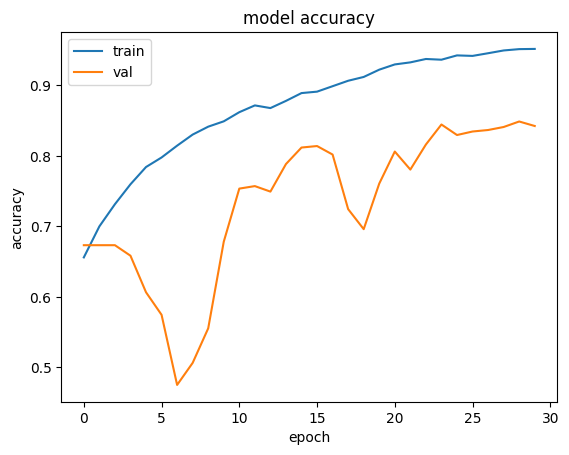

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

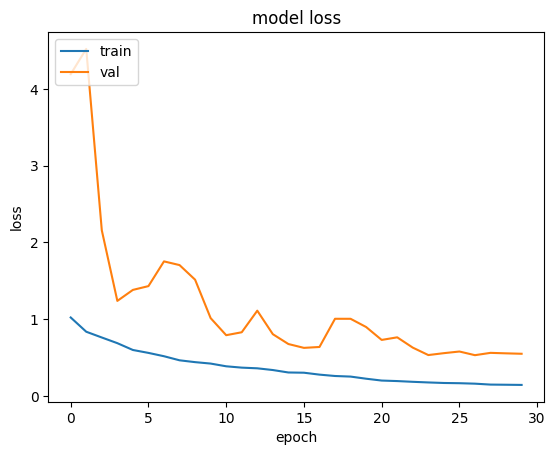

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

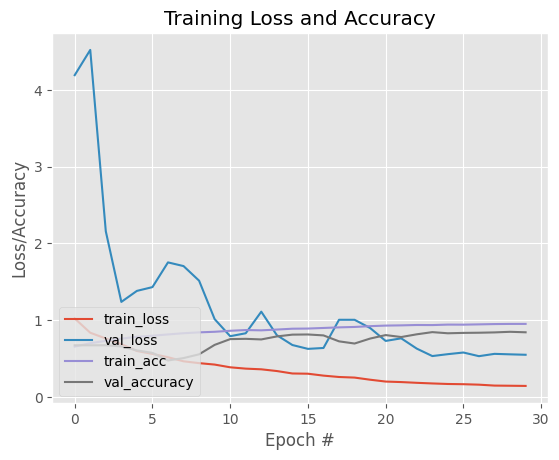

In [32]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [34]:
# Assuming you have already defined your model and test_data generator

# Reset the test_data generator
test_data.reset()

# Use the 'predict' method instead of 'predict_generator'
predictions = model.predict(test_data, steps=test_data.samples / test_data.batch_size, verbose=1)

# For binary classification, use argmax to get the predicted class (0 or 1)
y_pred = np.argmax(predictions, axis=1)


1703/1703 [==============================] - 33s 19ms/step


In [35]:
c = np.where(y_pred == name_as_indexes_test)

In [36]:
np.count_nonzero(c)

1417

In [37]:
print("Test Accuracy :",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy : 83.20610687022901


In [38]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(name_as_indexes_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.62      0.60      0.61        62
           1       0.74      0.74      0.74        77
           2       0.69      0.66      0.68       201
           3       0.73      0.33      0.46        24
           4       0.63      0.52      0.57       191
           5       0.90      0.94      0.92      1128
           6       0.82      0.90      0.86        20

    accuracy                           0.83      1703
   macro avg       0.73      0.67      0.69      1703
weighted avg       0.82      0.83      0.83      1703



In [39]:
model.save("model_1.h5")

C:\Users\rohit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
model.save("model_2.keras")